In [32]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import normalize
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
%matplotlib inline  


In [2]:
path = "/Users/weiweili/Documents/InterviewProjects/LoanData/"

In [3]:
data = pd.read_csv(path+"LoanData.csv")

In [4]:
data.shape

(39786, 22)

In [5]:
data.dtypes

loan_amnt            int64
term                object
int_rate            object
installment        float64
sub_grade           object
emp_length          object
home_ownership      object
annual_inc         float64
is_inc_v            object
loan_status         object
desc                object
purpose             object
addr_state          object
dti                float64
delinq_2yrs          int64
fico_range_low       int64
fico_range_high      int64
inq_last_6mths       int64
open_acc             int64
revol_bal            int64
revol_util          object
total_acc            int64
dtype: object

In [6]:
#merged "fico_range_high and ficco_range_low" to one field "fico_avg" by averaging the
#previous two fields.
data['fico_avg'] = data[['fico_range_low', 'fico_range_high']].mean(axis = 1)

In [7]:
data.drop(['fico_range_low', 'fico_range_high'],1, inplace = True)

In [8]:
#data.groupby('loan_status').count()

In [9]:
#1: charged off, default, late(16-30 days), late(31-120 days)
#0: current, fully paid, in grace period
data['loan_status'] = np.where((data['loan_status'] == 'Current') | 
                               (data['loan_status'] =='Fully Paid') |
                            (data['loan_status'] =='In Grace Period'), 0, 1)


In [10]:
#sub_grade col: create a dictionary for sub_grade, A1:1, A2:2,....
dictgrade = dict()
beginNum = ord('A')
endNum = ord('G')
count = 0
for number in range(beginNum, endNum+1):
    for num in range(1, 6):
        count += 1
        dictgrade[str(chr(number)) + str(num)] = count
        
data['sub_grade'] = data['sub_grade'].map(dictgrade)

In [11]:
# emp_length col
data = data[data['emp_length']!='n/a'] # remove missing values

emplen = [x[0] for x in data['emp_length'].str.split(' ')]
tmp = [10 if x=='10+'else x for x in emplen]
tmp = [1 if x=='<' else x for x in tmp]

data['emp_length'] = [float(x) for x in tmp]

In [12]:
#check if there is any nan value in the column
#data['desc'].isnull().values.any()
#how many nan value in the column
#data['desc'].isnull().sum().sum()

In [13]:
# desc col
desc = [0 if x is np.nan else len(x) for x in data['desc']] #fill Nan value as 0
data['desc'] = desc
data = data[data['desc'] != 0]  # remove missing values

In [14]:
# is_inc_v col: not verified: 0, verified: 1
incv = [sent[0].split()[0].lower() for sent in data['is_inc_v'].str.split('')]
incv = [0 if x == 'not' else 1 for x in incv]
data['is_inc_v'] = incv

In [15]:
# int_rate and revol_util col
int_rate = [x.replace('%','') for x in data['int_rate']]
data['int_rate'] = [float(x) for x in int_rate]
#fill Nan value as 0
revol_util = [0 if x is np.nan else x.replace('%','') for x in data['revol_util']] 
data['revol_util'] = [float(x) for x in revol_util]
data = data[data['revol_util'] != 0] #remove missing value

In [16]:
# term col
#term = [month[0].split()[0] for month in data['term'].str.split('')]
#term = [36 if x == '36' else 60 for x in term]
#data['term'] = term

In [17]:
#data.dtypes()

In [76]:
cols = ['home_ownership']+['purpose']+['addr_state']+['term']
cat_data = data[cols]

vec = DV()
cat_data = vec.fit_transform(cat_data.apply(dict,1)).toarray()
cat_features = vec.get_feature_names()


In [19]:
cols1 = cols+['loan_status']
dataExp = data.drop(cols1, axis = 1)
data_complete = np.concatenate((dataExp, cat_data), axis=1)

In [90]:
tot_features = np.concatenate((list(dataExp), cat_features), axis = 0)
tot_features[10]

'fico_avg'

In [20]:
#normalize data 
#Min_Max_Scalling: An alternative approach to Z-score normalization (or standardization) 
#Compare to standardization (Z-score normalization):
#Min_Max_Scalling end up with smaller standard deviations, which can suppress the effect of outliers.
#http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data_complete)
#pd.DataFrame(data_norm)

In [21]:
# seperate label from the dataset
label = data['loan_status'].astype(np.integer)

In [22]:
# split train and test datasets, train: 75% and test: 25%
train_features, test_features, train_target, test_target = train_test_split(data_norm, label, test_size = 0.25)

#train_features = pd.DataFrame(train_features)
#train_features.to_csv('train_features.csv', index=False, header=True)


In [23]:
####---------- Classification Models ------------ ####

In [24]:
# a function of calculating True positive, true negative, false positive, false negative
def perfmetrics(model, test, target):
# calculate TP, TN, FP, FN
    pred = model.predict(test)
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(0, len(test)):
        if 0.9 < pred[i] < 1.1:
            if 0.9 < target[i] < 1.1:
                TP += 1
            else:
                FP += 1
        else:
            if -0.1 < target[i] < 0.1:
                TN += 1
            else:
                FN += 1
    return (TP, TN, FP, FN)


In [25]:
#imbalanced data problem, will solve the problem by oversampling the minority class
#num_notDefault = sum(x == 0 for x in data['loan_status'])
#num_Default = sum(x == 1 for x in data['loan_status'])

#print len(data['loan_status']), num_notDefault, num_Default
print train_target.value_counts()
print test_target.value_counts()

0    16560
1     2578
Name: loan_status, dtype: int64
0    5512
1     868
Name: loan_status, dtype: int64


In [26]:
#solve imbalanced data problem: 
#1. oversample using SMOTE Algorithm: https://beckernick.github.io/oversampling-modeling/
#need to split x_train and x_validation first, in order to avoid the validation set has the synthetic data, which bleeds info.

x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size = 0.25)

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

print y_train.value_counts(), np.bincount(y_train_res)


0    12425
1     1928
Name: loan_status, dtype: int64 [12425 12425]


In [27]:
#'**** Random Forest ****'

In [28]:
# fit the model
rf = RandomForestClassifier(max_depth=5, max_features=10,random_state=12)
rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [29]:
#validation
print 'Validation Results'
print rf.score(x_val, y_val)
print recall_score(y_val, rf.predict(x_val))

#test
print '\nTest Results'
print rf.score(test_features, test_target)
print recall_score(test_target, rf.predict(test_features))
probs = rf.predict_proba(test_features)
cla = rf.predict(test_features)

Validation Results
0.608986415883
0.573846153846

Test Results
0.617868338558
0.58064516129


In [30]:
test_target_array = pd.Series.as_matrix(test_target)
TP, TN, FP, FN = perfmetrics(rf, test_features, test_target_array)

print 'True Positive', TP
print 'False Positive', FP
print 'True Negative', TN
print 'False Negative', FN

True Positive 504
False Positive 2074
True Negative 3438
False Negative 364


Feature ranking:
1. feature 10 (0.253638)
2. feature 15 (0.150015)
3. feature 1 (0.141456)
4. feature 3 (0.098721)
5. feature 9 (0.088878)
6. feature 86 (0.078275)
7. feature 6 (0.016782)
8. feature 13 (0.016496)
9. feature 82 (0.016153)
10. feature 7 (0.012777)


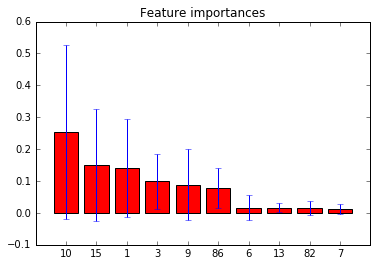

In [95]:
# Print the feature ranking
import matplotlib.pyplot as plt
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(11), indices[0:10])
plt.xlim([-1, 10])
plt.show()


In [96]:
features_imp = pd.Series(importances, index=tot_features).sort_values(ascending=False)
 
features_imp 

inq_last_6mths                0.253638
fico_avg                      0.150015
int_rate                      0.141456
sub_grade                     0.098721
delinq_2yrs                   0.088878
term= 60 months               0.078275
is_inc_v                      0.016782
revol_util                    0.016496
purpose=small_business        0.016153
desc                          0.012777
emp_length                    0.012515
loan_amnt                     0.012022
open_acc                      0.011909
revol_bal                     0.010826
purpose=car                   0.010027
annual_inc                    0.009148
installment                   0.008418
purpose=credit_card           0.008337
purpose=debt_consolidation    0.005574
total_acc                     0.004235
purpose=major_purchase        0.004123
addr_state=TX                 0.003694
addr_state=PA                 0.003649
dti                           0.003516
addr_state=FL                 0.002774
addr_state=RI            

6380
6380


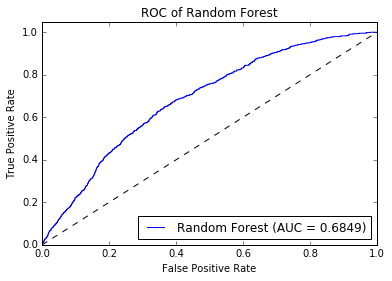

In [140]:
# plot ROC  #
#True positive: reject H0, when H0 is False     (Sensitivity : TPR = TP/N)
#False positive (type I error): reject H0, when H0 is true.
#True Negative: accept H0, when H0 is True      (specificity: TNR = TN/N)
#False Negative(type II error) =beta: accept H0, when H0 is False
#power(sensitivity) = 1- beta = 1- False Negative rate = True positive rate

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 2):
    fpr[i], tpr[i], hold1 = roc_curve(test_target, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  #auc: area under the curve

print len(test_target)
print len(probs[:, i])

plt.figure()
plt.plot(fpr[1], tpr[1], label='Random Forest (AUC = {0:0.4f})'.format(roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")

In [133]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=12)
lr.fit(x_train_res, y_train_res)
#print 'the accuracy of Logistic Regression is ', lr.score(test_features, test_target)
#lr = LogisticRegression(class_weight='auto')
#lr.fit(loan_train, target_train)
probs = lr.predict_proba(test_features)

In [134]:
#test
print '\nTest Results'
print lr.score(test_features, test_target)
print recall_score(test_target, lr.predict(test_features))



Test Results
0.637147335423
0.645161290323


In [135]:
TP, TN, FP, FN = perfmetrics(lr, test_features, test_target_array)

print 'True Positive', TP
print 'False Positive', FP
print 'True Negative', TN
print 'False Negative', FN

True Positive 560
False Positive 2007
True Negative 3505
False Negative 308


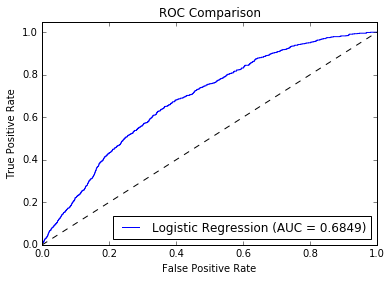

In [147]:
#Logistic Regression
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression()
#lr.fit(x_train_res, y_train_res)
#print 'the accuracy of Logistic Regression is ', lr.score(test_features, test_target)
#print 'the accuracy of balanced test data set is ', lr.score(loan_test_b, target_test_b)


#probs = lr.predict_proba(test_features)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 2):
    fpr[i], tpr[i], hold1 = roc_curve(test_target, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plt.figure()
plt.plot(fpr[1], tpr[1], label='Logistic Regression (AUC = {0:0.4f})'.format(roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend(loc="lower right")
plt.show()

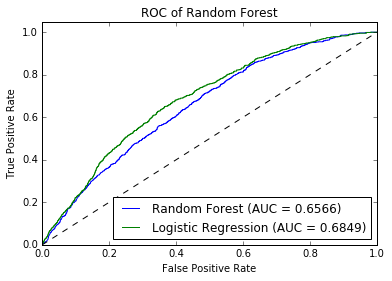

In [146]:
plt.figure(0).clf()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
probs = rf.predict_proba(test_features)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 2):
    fpr[i], tpr[i], hold1 = roc_curve(test_target, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  #auc: area under the curve



plt.plot(fpr[1], tpr[1], label='Random Forest (AUC = {0:0.4f})'.format(roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")

probs = lr.predict_proba(test_features)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, 2):
    fpr[i], tpr[i], hold1 = roc_curve(test_target, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[1], tpr[1], label='Logistic Regression (AUC = {0:0.4f})'.format(roc_auc[1]))

plt.legend(loc=0)
